<a href="https://colab.research.google.com/github/SainRigo/yolov9_prunn_20/blob/main/train_yolov9_object_detection_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Feb 26 11:07:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

In [3]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 147 (delta 16), reused 14 (delta 14), pack-reused 122
Receiving objects: 100% (147/147), 607.60 KiB | 14.13 MiB/s, done.
Resolving deltas: 100% (58/58), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.0 MB/s eta 0:00:00


**NOTE:** Let's install additional packages that will be useful later on.

In [4]:
!pip install -q roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00


## Imports

In [5]:
import roboflow

from IPython.display import Image

## Download model weights

**NOTE:** In the YOLOv9 paper, versions yolov9-s and yolov9-m are also mentioned, but the weights for these models are not yet available in the YOLOv9 repository.

In [6]:
!mkdir -p {HOME}/weights

In [7]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [8]:
!ls -la {HOME}/weights

total 402440
drwxr-xr-x 2 root root      4096 Feb 26 11:07 .
drwxr-xr-x 1 root root      4096 Feb 26 11:07 ..
-rw-r--r-- 1 root root  51508261 Feb 18 12:36 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18 12:36 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18 12:36 yolov9-e.pt


## Download example data

## Detection with pre-trained COCO model

## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [11]:
%cd {HOME}/yolov9

roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("plums-hhqfx").project("plums-0ucd7")
dataset = project.version(3).download("yolov9")

/content/yolov9
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plums-3 in yolov9:: 100%|██████████| 14952/14952 [00:02<00:00, 5989.13it/s]


## Train Custom Model

In [18]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 20 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2024-02-26 11:18:20.824133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 11:18:20.824188: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 11:18:20.825517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-26 11:18:21.895019: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=/content/weights/gelan-c.pt, cfg=models/detect/gelan-c.yaml, data=/content/yolov9/plums-3/data.yaml, hyp=hyp.scratch-high.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [14]:
!ls {HOME}/yolov9/runs/train/exp/

events.out.tfevents.1708945749.e231781918e6.1674.0  hyp.yaml  opt.yaml	weights


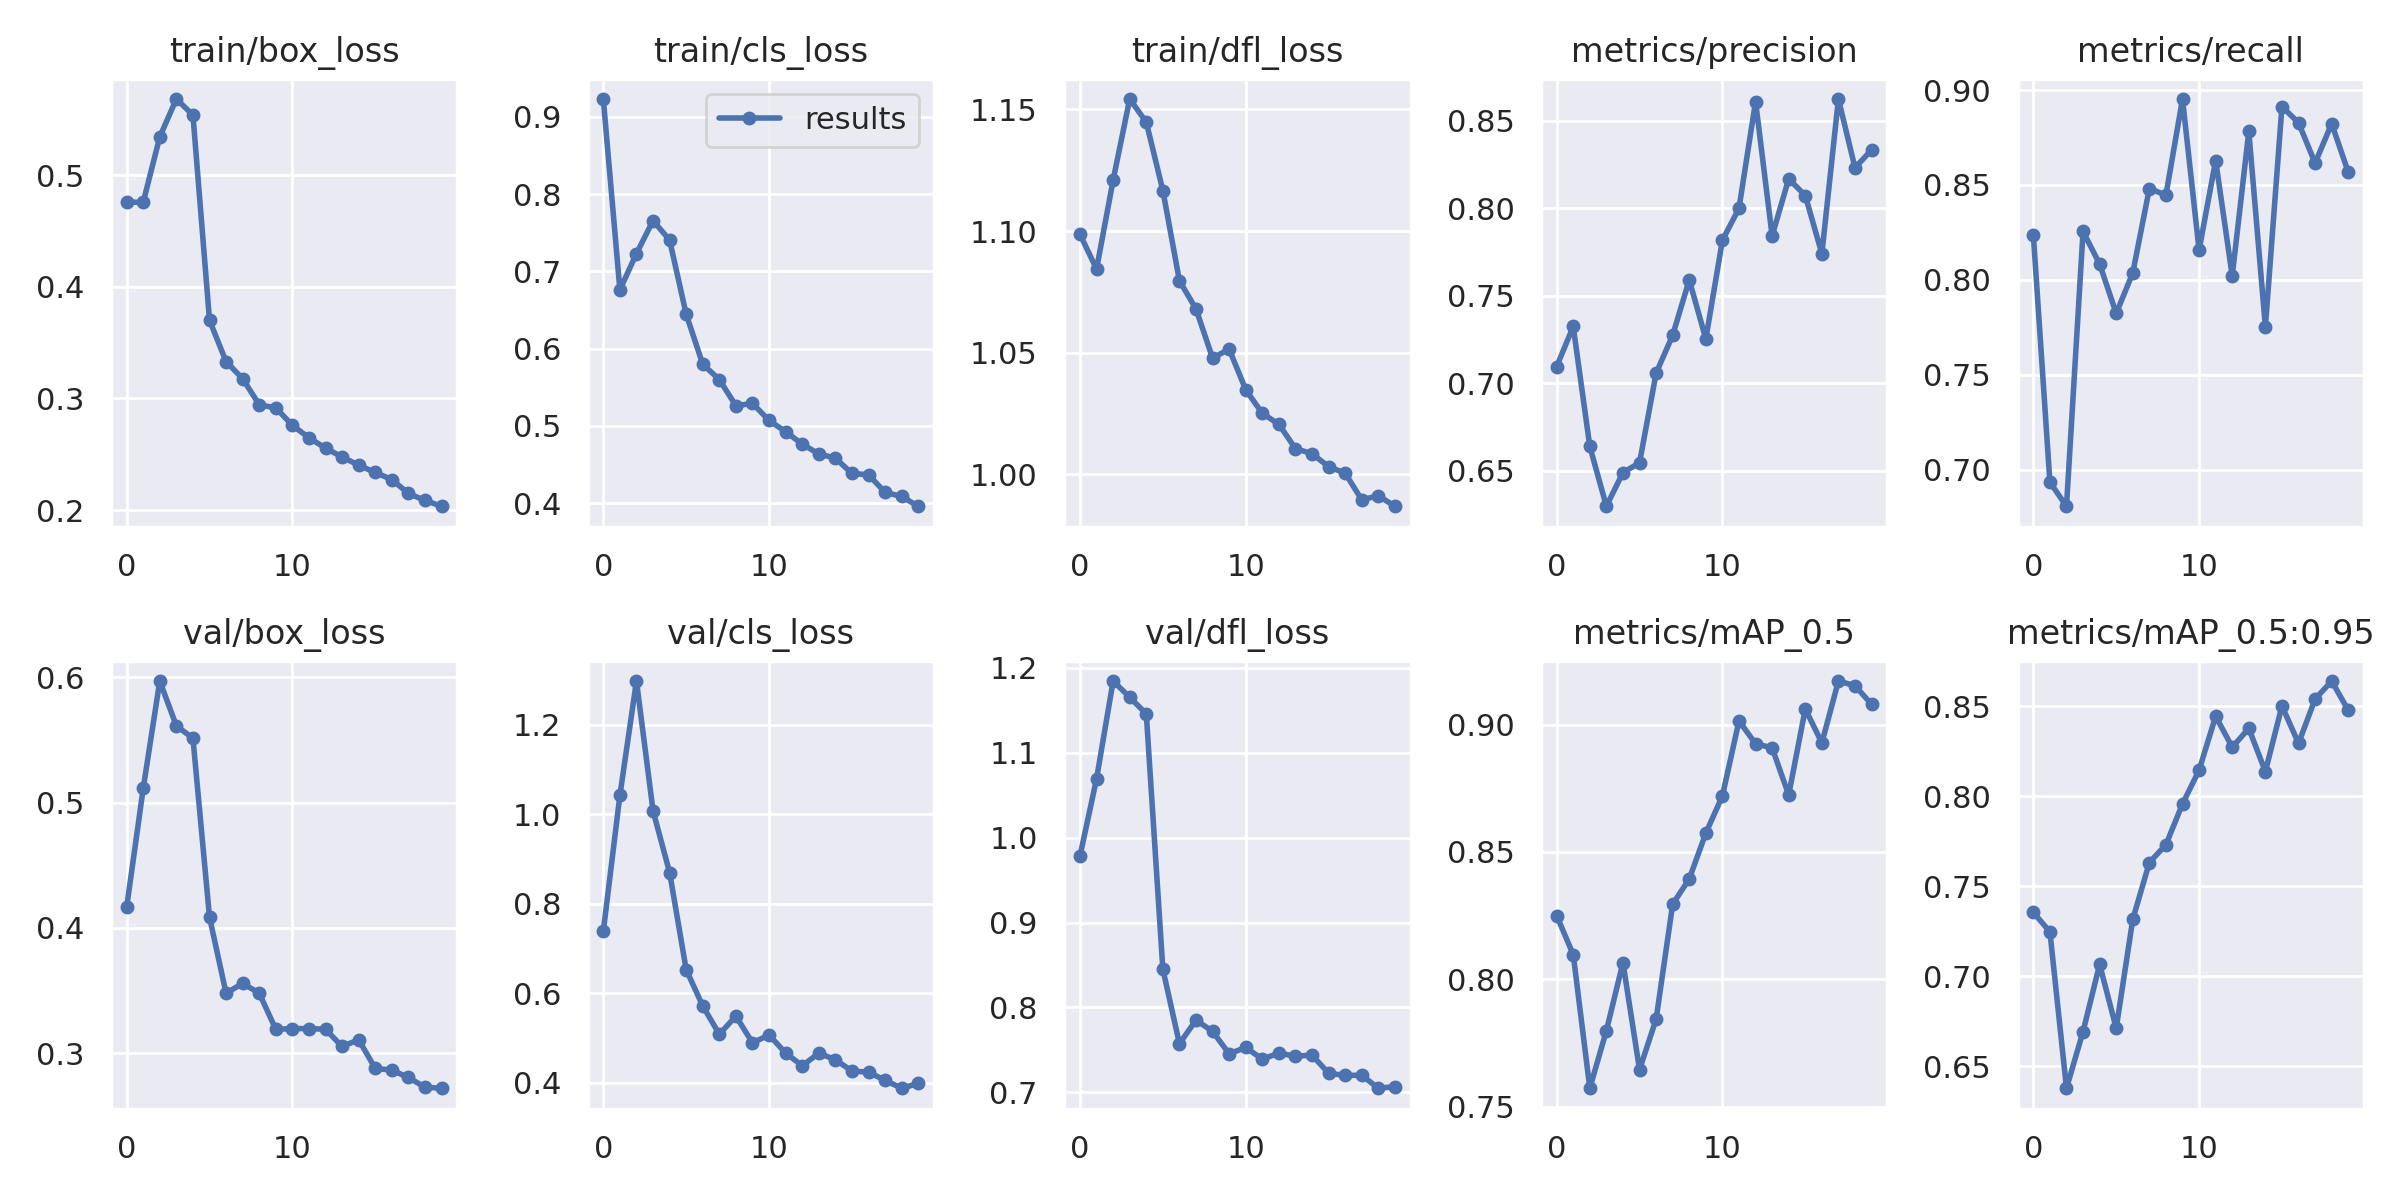

In [19]:
Image(filename=f"{HOME}/yolov9/runs/train/exp5/results.png", width=1000)

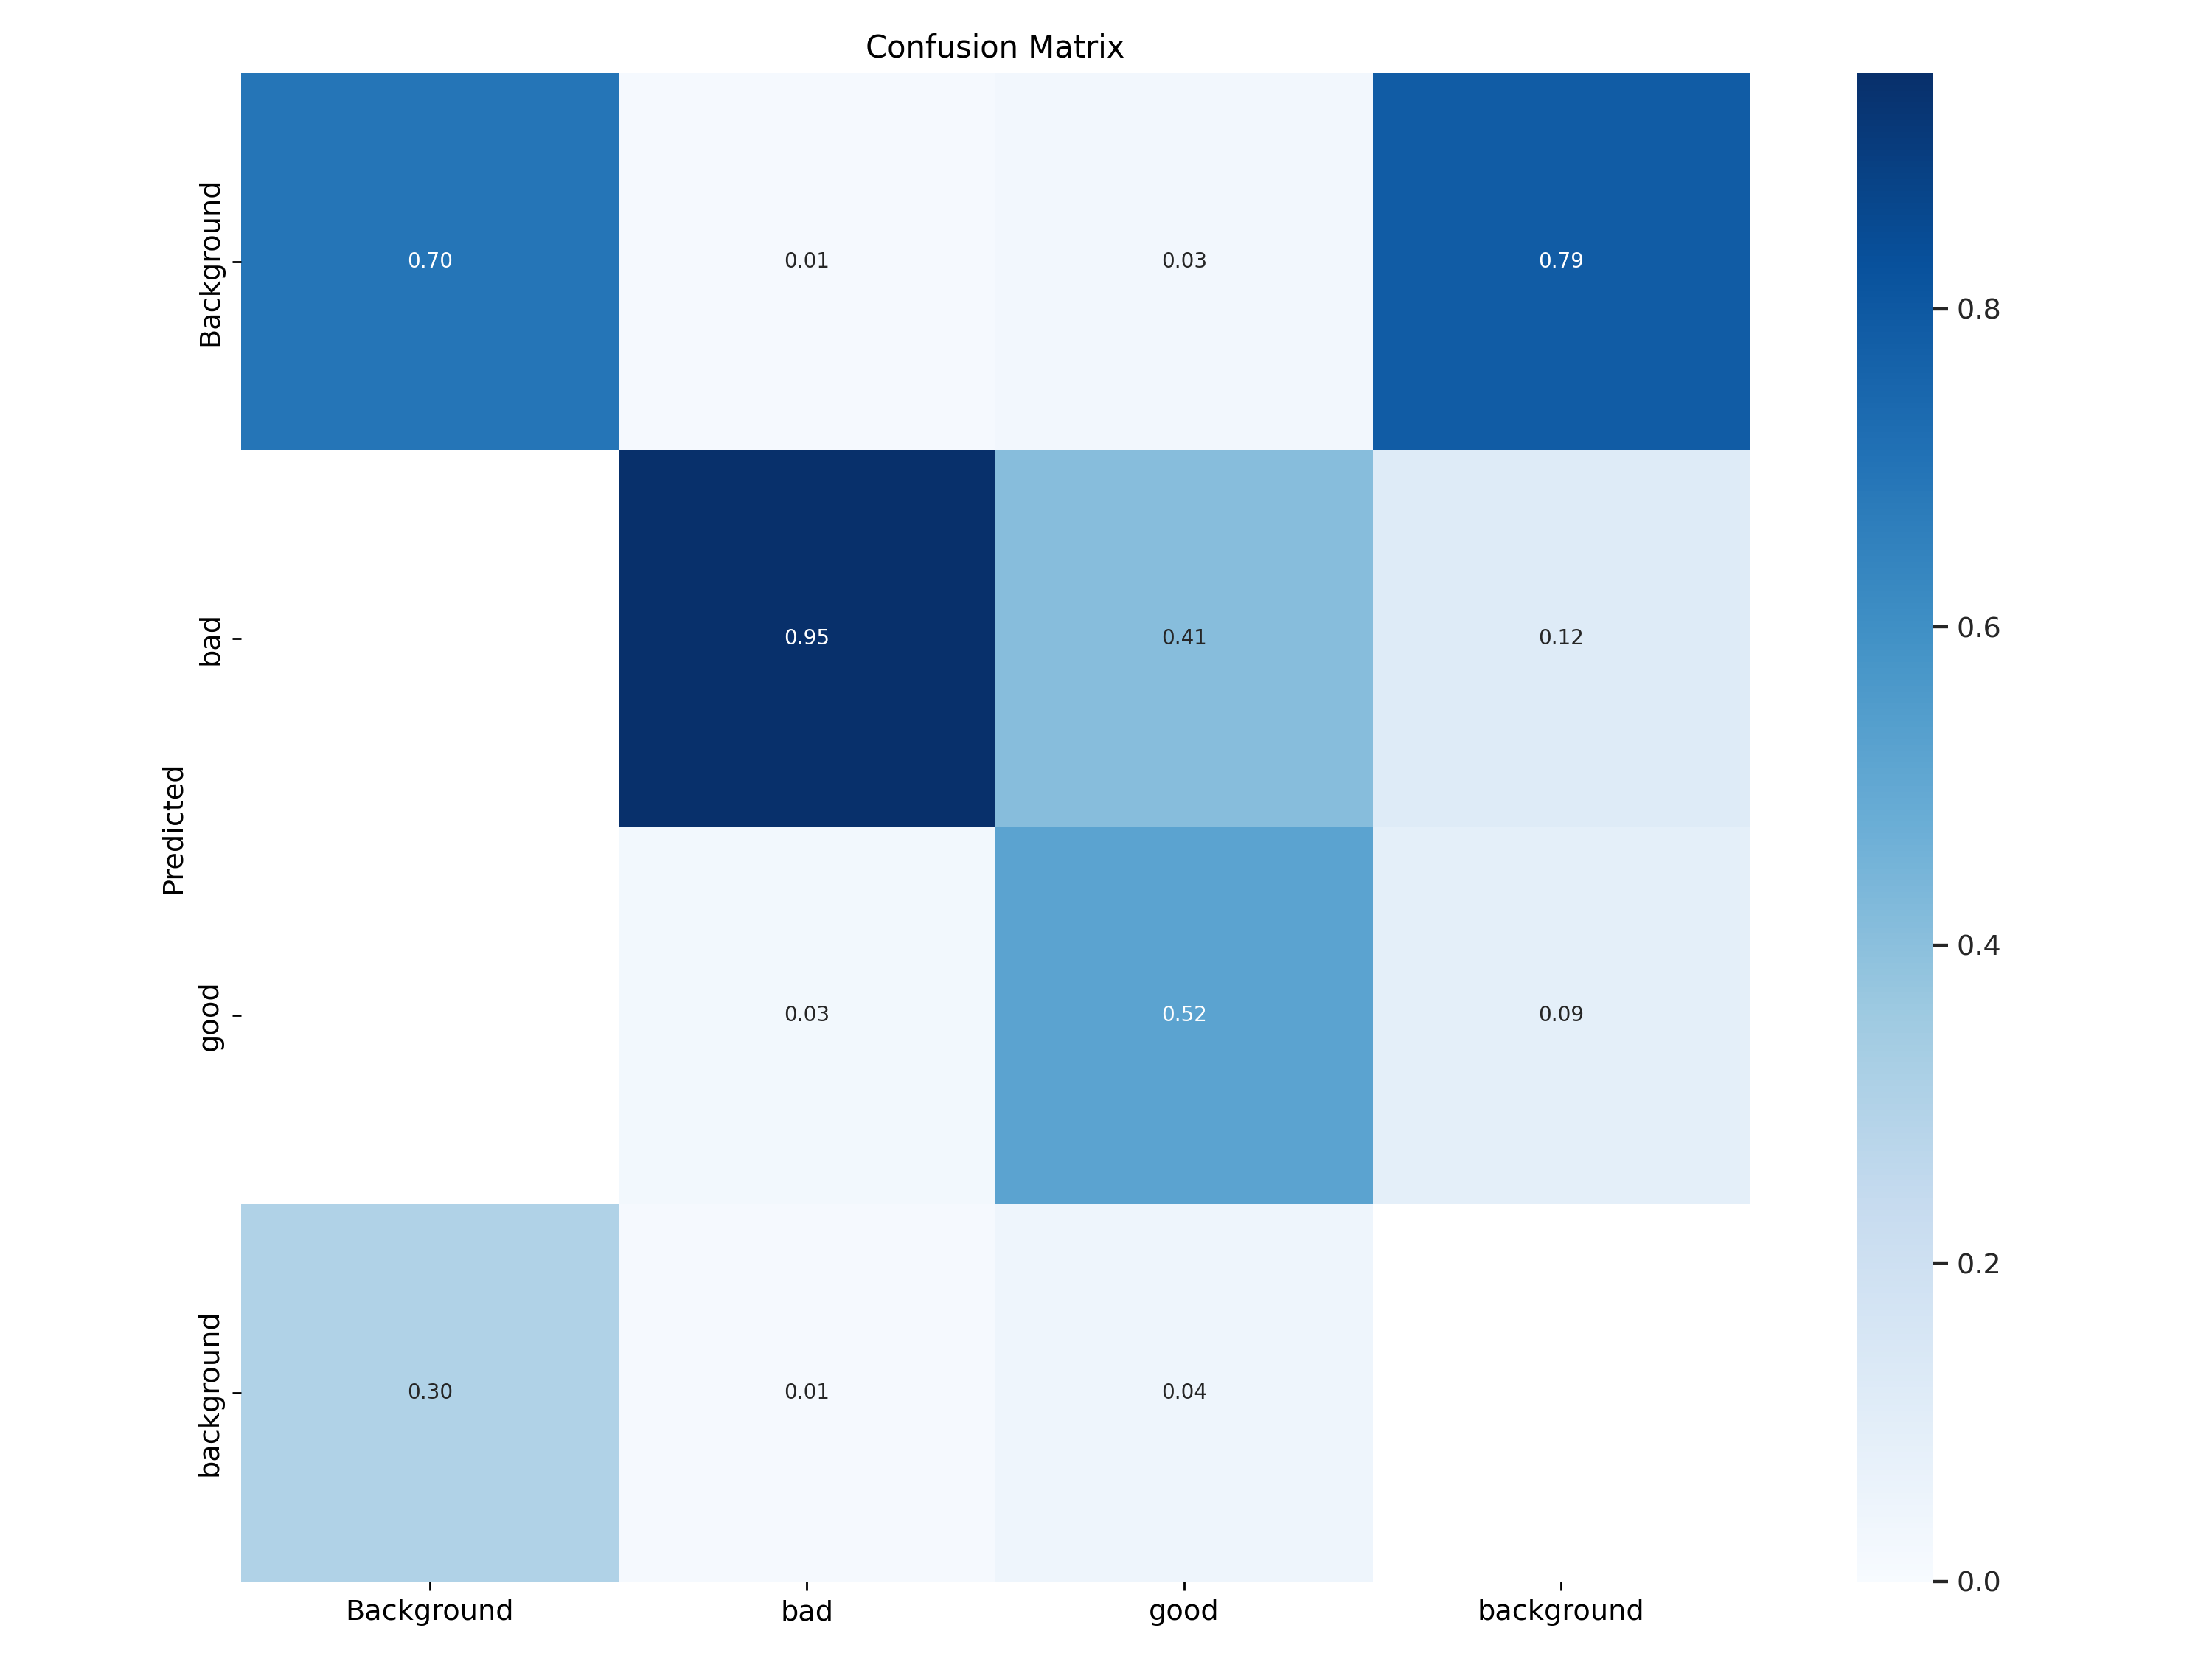

In [20]:
Image(filename=f"{HOME}/yolov9/runs/train/exp5/confusion_matrix.png", width=1000)

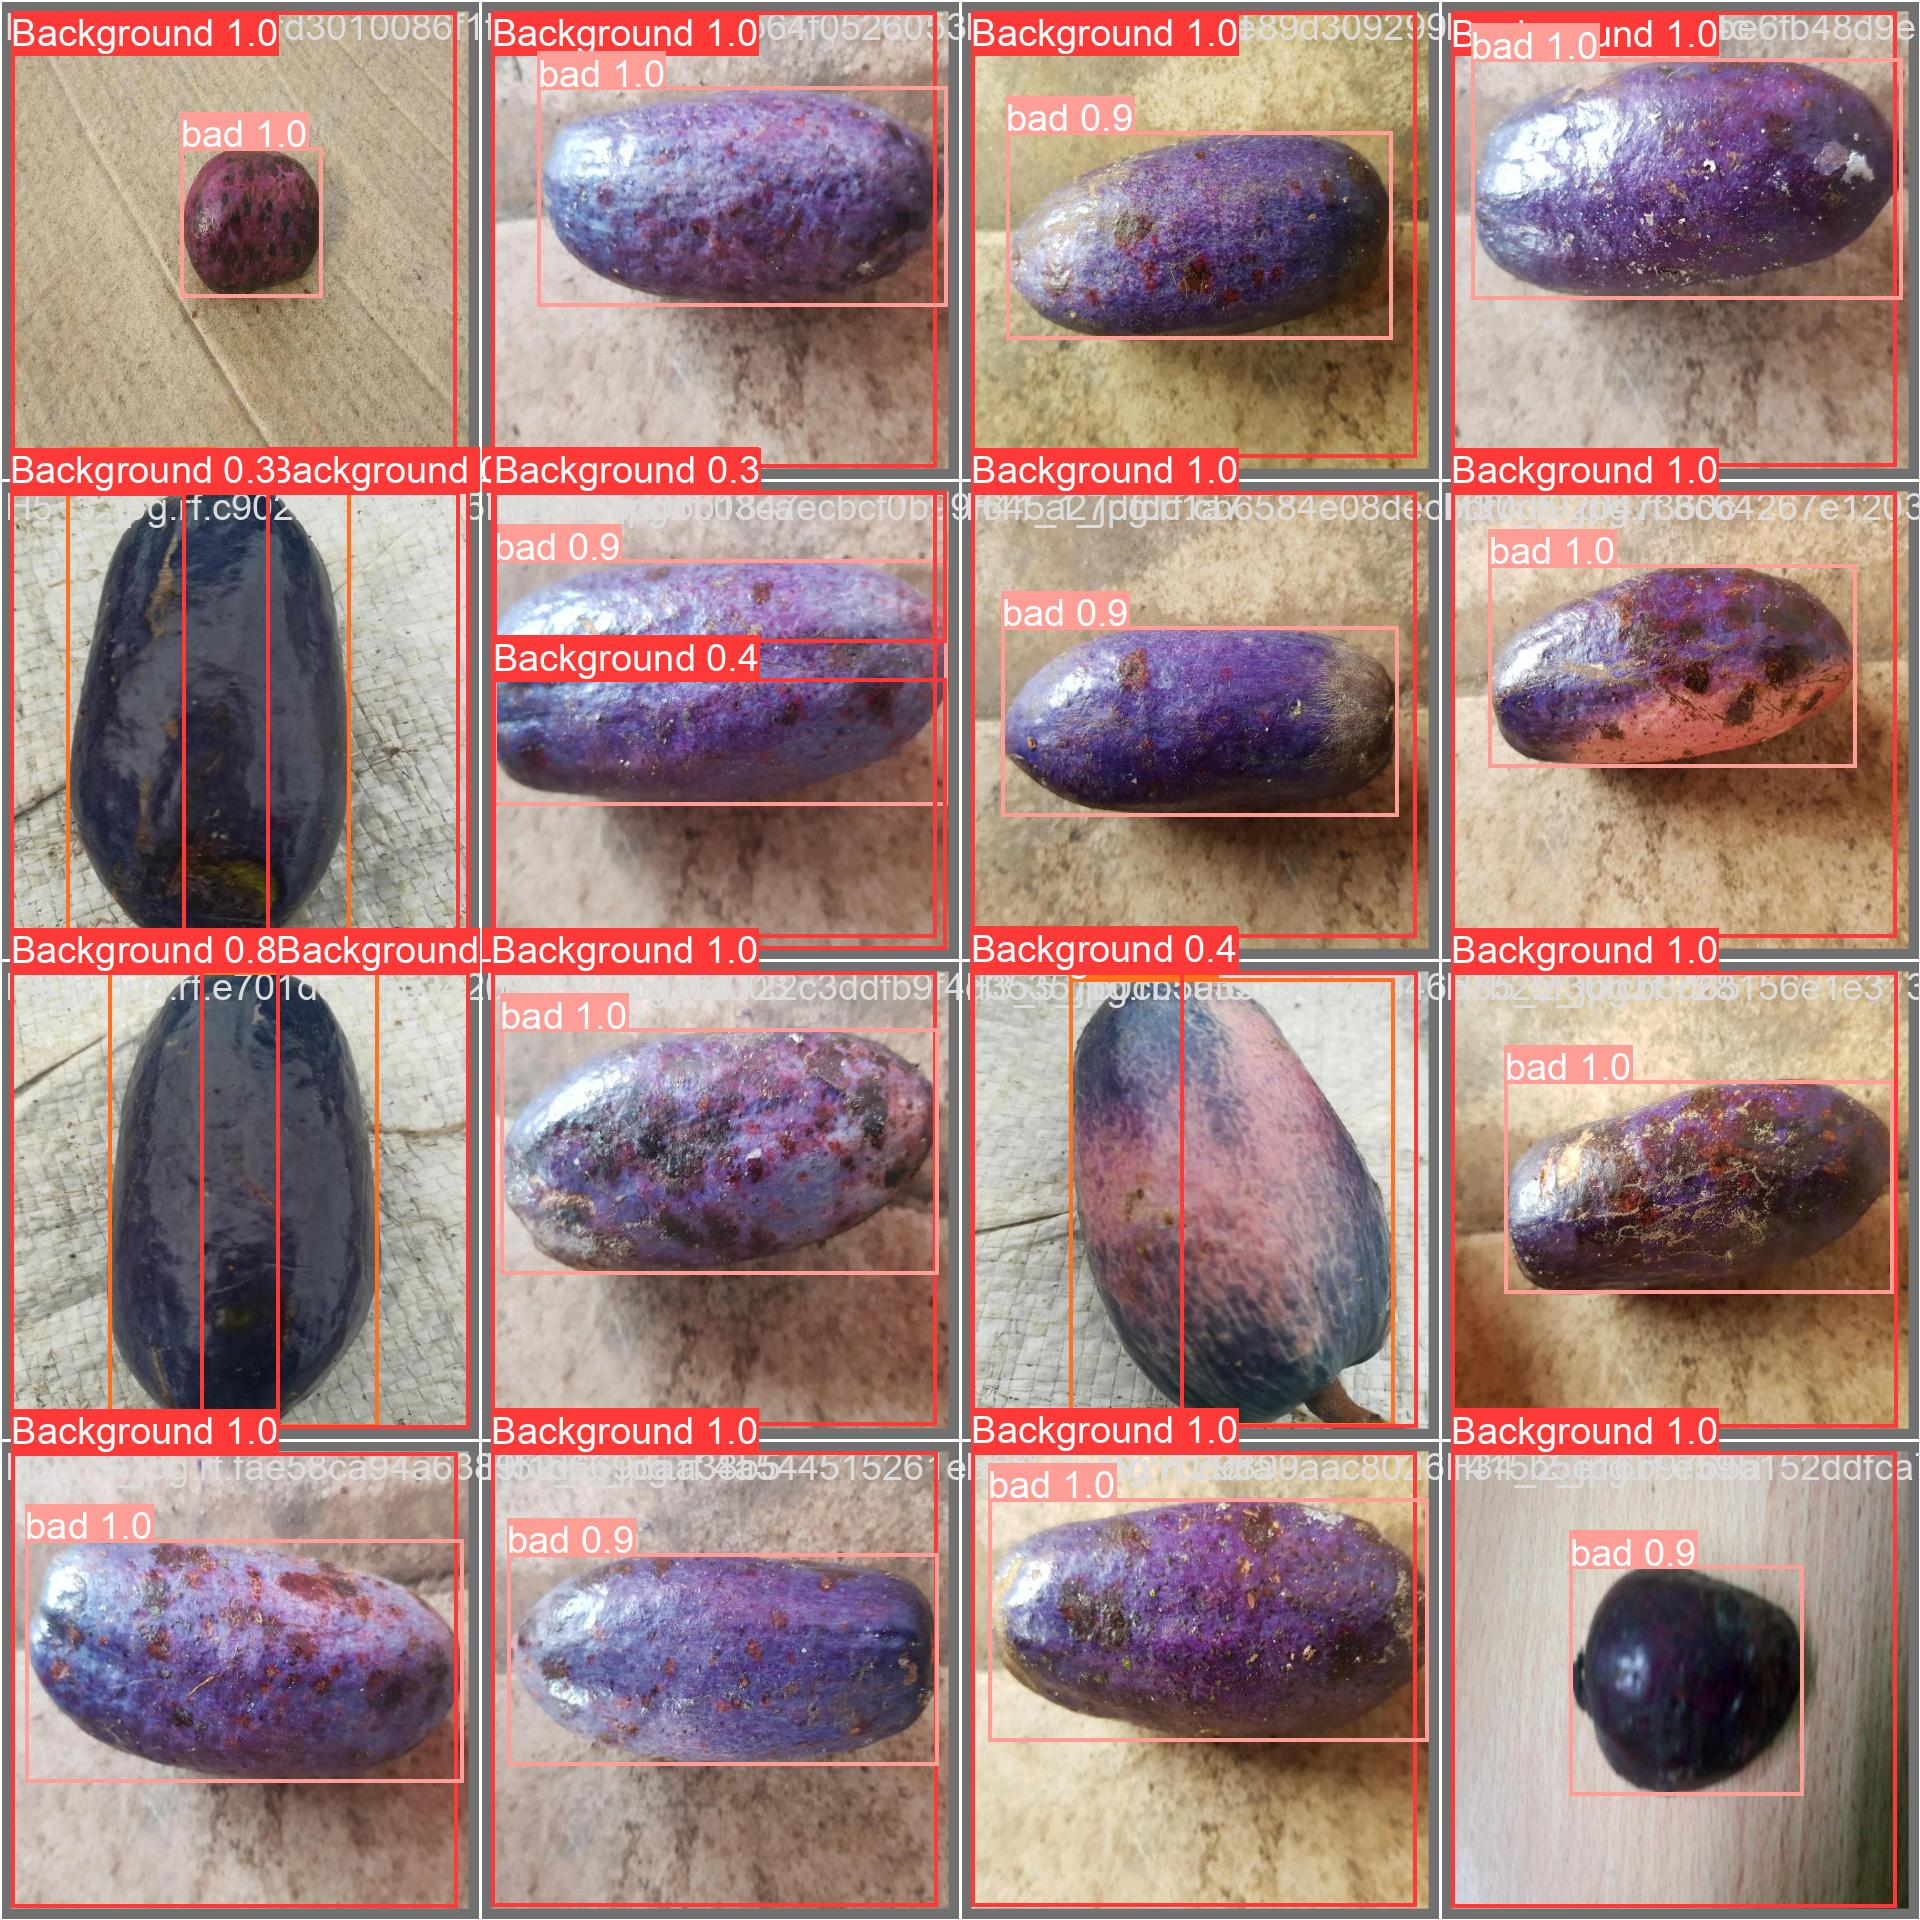

In [21]:
Image(filename=f"{HOME}/yolov9/runs/train/exp5/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [24]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp5/weights/best.pt

/content/yolov9
val: data=/content/yolov9/plums-3/data.yaml, weights=['/content/yolov9/runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-3/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:21<00:00,  1.46s/it]
                   all        453       1184      0.824      0.882      0.915      0.865
            Background        453        726      0.829      0.

In [23]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 9.0 MB/s eta 0:00:00


In [29]:
import torch, torch.nn as nn
from torch.nn.utils import prune
from ultralytics import YOLO

model = YOLO("/content/yolov9/runs/train/exp5/weights/best.pt")


def sparsity(model):
    # Return global model sparsity
    a, b = 0, 0
    for p in model.parameters():
        a += p.numel()
        b += (p == 0).sum()
    return b / a

pruning_param = 0.2

for name, m in model.model.named_modules():
    if isinstance(m, nn.Conv2d) or isinstance(m, torch.nn.Linear):
        prune.l1_unstructured(m, name='weight', amount=pruning_param)  # prune
        prune.remove(m, 'weight')  # make permanent
print(f'Model pruned to {sparsity(model.model):.3g} global sparsity')

ckpt = {

            'model': model.model,
            'train_args': {},  # save as dict
}

torch.save(ckpt, '../model_pruned_3.pt')



Model pruned to 0.2 global sparsity


In [30]:
model = YOLO("../model_pruned_3.pt")

In [31]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights ../model_pruned_3.pt

/content/yolov9
val: data=/content/yolov9/plums-3/data.yaml, weights=['../model_pruned_3.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
gelan-c summary: 467 layers, 25413273 parameters, 0 gradients, 102.5 GFLOPs
val: Scanning /content/yolov9/plums-3/valid/labels.cache... 453 images, 0 backgrounds, 0 corrupt: 100% 453/453 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:22<00:00,  1.47s/it]
                   all        453       1184      0.758      0.885      0.881      0.776
            Background        453        726       0.83      0.848      0.915      0.799
 